# Self-Supervised Monocular Depth Estimation

In [1]:
from dataloader import KittiDataset
from transformation import ToResizeImage, ToRandomFlip, ToTensor, AugumentImagePair
from model import Model

import torch
from torch.utils.data import DataLoader

import os
import numpy as np
import random
import skimage.transform
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
import torchvision.transforms.functional as tF

## Data Loading

In [2]:
train_path = os.path.join(os.getcwd(), 'data/train')
test_path = os.path.join(os.getcwd(), 'data/test')

In [3]:
train_transform = transforms.Compose([
    ToResizeImage(),
    ToRandomFlip(),
    ToTensor(),
    AugumentImagePair(),
])
test_transform = transforms.Compose([
    ToResizeImage(),
    ToTensor(),
])

In [4]:
train_set = KittiDataset(train_path, 'train', transform = train_transform)
test_set = KittiDataset(test_path, 'test', transform = test_transform)

train_loader = DataLoader(train_set, batch_size = 5, shuffle = True)
test_loader = DataLoader(test_set, batch_size = 77, shuffle = False)

## Implement CNN using PyTorch

In [5]:
model = Model(train_loader=train_loader,
              test_loader=test_loader,
              device='cpu', 
              epochs=1, 
              save_per_epoch=10, 
              img_height=256, 
              img_width=512, 
              model_path='output_model', 
              disp_path='output_disp')

In [6]:
# loss = model.train()

In [7]:
model.test('output_model/0.pt')

[[0.         0.00195695 0.00391389 ... 0.99608611 0.99804305 1.        ]
 [0.         0.00195695 0.00391389 ... 0.99608611 0.99804305 1.        ]
 [0.         0.00195695 0.00391389 ... 0.99608611 0.99804305 1.        ]
 ...
 [0.         0.00195695 0.00391389 ... 0.99608611 0.99804305 1.        ]
 [0.         0.00195695 0.00391389 ... 0.99608611 0.99804305 1.        ]
 [0.         0.00195695 0.00391389 ... 0.99608611 0.99804305 1.        ]] [[0.         0.         0.         ... 0.         0.         0.        ]
 [0.00392157 0.00392157 0.00392157 ... 0.00392157 0.00392157 0.00392157]
 [0.00784314 0.00784314 0.00784314 ... 0.00784314 0.00784314 0.00784314]
 ...
 [0.99215686 0.99215686 0.99215686 ... 0.99215686 0.99215686 0.99215686]
 [0.99607843 0.99607843 0.99607843 ... 0.99607843 0.99607843 0.99607843]
 [1.         1.         1.         ... 1.         1.         1.        ]]
[[0.         0.00195695 0.00391389 ... 0.99608611 0.99804305 1.        ]
 [0.         0.00195695 0.00391389 ... 

[[0.         0.00195695 0.00391389 ... 0.99608611 0.99804305 1.        ]
 [0.         0.00195695 0.00391389 ... 0.99608611 0.99804305 1.        ]
 [0.         0.00195695 0.00391389 ... 0.99608611 0.99804305 1.        ]
 ...
 [0.         0.00195695 0.00391389 ... 0.99608611 0.99804305 1.        ]
 [0.         0.00195695 0.00391389 ... 0.99608611 0.99804305 1.        ]
 [0.         0.00195695 0.00391389 ... 0.99608611 0.99804305 1.        ]] [[0.         0.         0.         ... 0.         0.         0.        ]
 [0.00392157 0.00392157 0.00392157 ... 0.00392157 0.00392157 0.00392157]
 [0.00784314 0.00784314 0.00784314 ... 0.00784314 0.00784314 0.00784314]
 ...
 [0.99215686 0.99215686 0.99215686 ... 0.99215686 0.99215686 0.99215686]
 [0.99607843 0.99607843 0.99607843 ... 0.99607843 0.99607843 0.99607843]
 [1.         1.         1.         ... 1.         1.         1.        ]]
[[0.         0.00195695 0.00391389 ... 0.99608611 0.99804305 1.        ]
 [0.         0.00195695 0.00391389 ... 

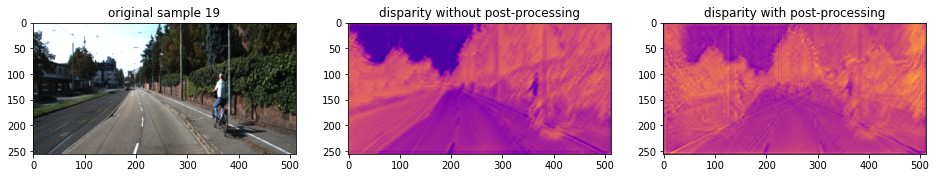

In [8]:
# plot original image
test_size = len(test_loader.dataset)

idx = random.randint(0, test_size)

for data in test_loader:
    img = data['left_image'][idx].permute(1,2,0)

disp = np.load('output_disp/disparities.npy')
disp_pp = np.load('output_disp/disparities_pp.npy')

disp_to_img = skimage.transform.resize(disp[idx].squeeze(), [256, 512], mode='constant')
disp_pp_to_img = skimage.transform.resize(disp_pp[idx].squeeze(), [256, 512], mode='constant')

fig = plt.figure(figsize=(16, 12))

ax = fig.add_subplot(1,3,1)
plt.title('original sample ' + str(idx))
plt.imshow(img, cmap='plasma')

ax = fig.add_subplot(1,3,2)
plt.title('disparity without post-processing')
plt.imshow(disp_to_img, cmap='plasma')

ax = fig.add_subplot(1,3,3)
plt.title('disparity with post-processing')
plt.imshow(disp_pp_to_img, cmap='plasma')